In [1]:
import os
import pandas as pd
import numpy as np


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score,  mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer as SklearnKNNImputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression


In [3]:
#impute for 400+ ppl missing FORMER_REG + JOB_REG - done 
#do imputation for people with "Retired_missing" + "Employed_missing" labels
#check the command about encoding part linear model

## Load data

In [4]:
for file_name in os.listdir("files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join("files", file_name)

        df_name = os.path.splitext(file_name)[0]
        globals()[df_name] = pd.read_csv(file_path)


## Simplification of categories

In [5]:
# Merge sports data and extract sports categories
def extract_sports_category(dataset, sports_code):
    merged = pd.merge(dataset, sports_code, left_on="Sports", right_on="Code")
    merged["Sports_Category"] = merged["Categorie"]
    return merged[["PRIMARY_KEY", "Sports_Category"]]

learn_sports = extract_sports_category(learn_dataset_sport, code_Sports)
test_sports = extract_sports_category(test_dataset_sport, code_Sports)

# Merge departments into regions and extract relevant region columns
def merge_and_extract_region(df, merge_column, region_column_name):
    merged = pd.merge(df, departments, left_on=merge_column, right_on="DEP", how="left")
    merged[region_column_name] = merged["REG"]
    return merged.drop(["Nom du département", "REG", "DEP", merge_column], axis=1)

In [6]:
learn_dataset_job = merge_and_extract_region(learn_dataset_job, "JOB_DEP", "JOB_REG")    #put the column as int 
learn_dataset_retired_jobs = merge_and_extract_region(learn_dataset_retired_jobs, "JOB_DEP", "JOB_REG")
learn_dataset_retired_jobs = merge_and_extract_region(learn_dataset_retired_jobs, "FORMER_DEP", "FORMER_REG")

test_dataset_job = merge_and_extract_region(test_dataset_job, "JOB_DEP", "JOB_REG")
test_dataset_retired_jobs = merge_and_extract_region(test_dataset_retired_jobs, "JOB_DEP", "JOB_REG")
test_dataset_retired_jobs = merge_and_extract_region(test_dataset_retired_jobs, "FORMER_DEP", "FORMER_REG")

In [7]:
#Economic sector into fewer categories (and numeric instead of object/string)
def sector_mapping(nace_code):
    if nace_code == "AZ":  
        return "Agriculture, forestry and fishing)"
    elif "BZ" <= nace_code <= "EZ":
        return "Manufacturing, mining and quarrying and other industrial activities"
    elif nace_code == "FZ": 
        return "Construction"
    elif "GZ" <= nace_code <= "IZ":  
        return "Wholesale and retail trade, transportation and storage, accommodation and food service activities"
    elif "JA" <= nace_code <= "JC":
        return "Information and communication"
    elif nace_code == "KZ": 
        return "Financial and insurance activities"
    elif nace_code == "LZ": 
        return "Real estate activities"
    elif "MA" <= nace_code <= "NZ":
        return "Professional, scientific, technical, administrative and support service activities"
    elif "OZ" <= nace_code <= "QB":
        return "Public administration and defence, education, human health and social work activities"
    elif "RZ" <= nace_code <= "UZ":
        return "Other services activities"
    else:
        return "Unknown Sector"

In [8]:
code_Economic_sector["Nomenclature"] = code_Economic_sector["Code"].map(sector_mapping)
code_Economic_sector["Economic_sector_num"] = pd.factorize(code_Economic_sector["Nomenclature"])[0] + 1

#issue in the code IZ should be its own category "Hébergement et restauration"
#HZ, JZ à MC so LZ, KZ, MA, MB and MC, NZ, OZ, PZ,  QA, QB, RZ, SZ, TZ et UZ should be in the same category

In [9]:
code_HIGHEST_CREDENTIAL["HIGHEST_CREDENTIAL_num"] = pd.factorize(code_HIGHEST_CREDENTIAL["Code"])[0] + 1
code_act["act_num"] = pd.factorize(code_act["Code"])[0] + 1

## Merging

In [10]:
learn_data = learn_dataset

learn_data = pd.merge(learn_data, code_act, left_on="act", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé"], axis=1, inplace=True)  #should also drop act ?
learn_data = pd.merge(learn_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

#for imputation fitting
learn_data = pd.merge(learn_data, city_pop, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_loc, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_adm, on="INSEE_CODE", how="left")
learn_data = merge_and_extract_region(learn_data, "DEP", "CURRENT_REG")

test_data = test_dataset

test_data = pd.merge(test_data, code_act, left_on="act", right_on="Code", how="left")
test_data.drop(["Code", "Libellé"], axis=1, inplace=True)
test_data = pd.merge(test_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
test_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

test_data = pd.merge(test_data, city_pop, on="INSEE_CODE", how="left")
test_data = pd.merge(test_data, city_loc, on="INSEE_CODE", how="left")
test_data = pd.merge(test_data, city_adm, on="INSEE_CODE", how="left")
test_data = merge_and_extract_region(test_data, "DEP", "CURRENT_REG")

In [11]:
learn_dfs = [learn_dataset_emp_contract, learn_dataset_job, learn_dataset_retired_former, 
             learn_dataset_retired_jobs, learn_dataset_retired_pension, learn_sports]

test_dfs = [test_dataset_emp_contract, test_dataset_job, test_dataset_retired_former, 
            test_dataset_retired_jobs, test_dataset_retired_pension, test_sports]

for df in learn_dfs:
    learn_data = pd.merge(learn_data, df, on="PRIMARY_KEY", how="outer")

for df in test_dfs:
    test_data = pd.merge(test_data, df, on="PRIMARY_KEY", how="outer")

In [12]:
# Function to combine columns ending with `_x` and `_y` into a single base column
def combine_duplicate_columns(dataframe):
    for column in dataframe.columns:
        if column.endswith('_x'):
            base_column = column[:-2]  # Remove `_x` suffix
            y_column = base_column + '_y'
            if y_column in dataframe.columns:
                # Combine the `_x` and `_y` columns
                dataframe[base_column] = dataframe[column].fillna(dataframe[y_column])
                # Drop the original `_x` and `_y` columns
                dataframe.drop(columns=[column, y_column], inplace=True)
    return dataframe

# Apply the function to both datasets
learn_data = combine_duplicate_columns(learn_data)
test_data = combine_duplicate_columns(test_data)


## Formatting 

In [13]:
def household_num(value):
    parts = value.split('|')  # Split the value by '|'
    if parts[1] in {'1', '2', '3'}:  # For M|1|-- to M|3|--
        return int(parts[1])
    elif parts[1] == '4':  # For M|4|1 to M|4|4
        return 4 + (int(parts[2]) - 1)  # 4 + (1-1), 4 + (2-1), etc.
    return None  # Handle unexpected cases gracefully

In [14]:
code_HOUSEHOLD_TYPE['HOUSEHOLD_TYPE_num'] = code_HOUSEHOLD_TYPE['Code'].apply(household_num)
learn_data['HOUSEHOLD_TYPE'] = learn_data['HOUSEHOLD_TYPE'].apply(household_num)
test_data['HOUSEHOLD_TYPE'] = test_data['HOUSEHOLD_TYPE'].apply(household_num)

In [15]:
def combine_columns(primary_col, fallback_col):
    """Combine two columns, filling missing values in the primary column with values from the fallback column."""
    return primary_col.fillna(fallback_col) if fallback_col is not None else primary_col

def preprocess_employee_data(data, economic_sector_code, work_description_map):
    # Extract numeric values from specific string columns
    data["employee_count"] = data["employee_count"].str.extract(r'tr_(\d)')[0].astype("Int64")
    data["Employer_category"] = data["Employer_category"].str.extract(r'ct_(\d)')[0].astype("Int64")
    
    # Merge with economic sector codes
    data = data.merge(economic_sector_code, left_on="Economic_sector", right_on="Code", how="left")
    
    # Merge with work description map and clean up columns
    data = data.merge(work_description_map, left_on="work_description", right_on="N3", how="left")
    data.drop(["work_description", "N3", "N2"], axis=1, inplace=True)
    data["work_description"] = data["N1"].str.extract(r'csp_(\d)')[0].astype("Int64")
    data.drop("N1", axis=1, inplace=True)
    
    # Combine relevant columns for contracts and pay
    data["emp_contract"] = combine_columns(data["emp_contract"], data["former_emp_contract"])
    data["Pay"] = combine_columns(data["Pay"], data["RETIREMENT_PAY"])
    
    return data

# Apply preprocessing to both learn and test datasets
learn_data = preprocess_employee_data(learn_data, code_Economic_sector, code_work_description_map)
test_data = preprocess_employee_data(test_data, code_Economic_sector, code_work_description_map)

In [16]:
def categorize_retirement_age(data):
    # Ensure the retirement_age column is numeric
    data['retirement_age'] = pd.to_numeric(data['retirement_age'], errors='coerce')
    
    # Define the bins and corresponding labels
    bins = [0, 57, 60, 61, 63, 65, float('inf')]  # Specify edges for the ranges
    labels = ['<57', '57-59', '60', '61-62', '63-64', '65+']  # Labels for ranges

    # Categorize retirement_age into retirement_age_cat
    data['retirement_age_cat'] = pd.cut(
        data['retirement_age'], 
        bins=bins, 
        labels=labels, 
        right=False,  # Left-closed intervals
        include_lowest=True
    )
    
    # Ensure missing values in retirement_age_cat are handled properly
    data['retirement_age_cat'] = data['retirement_age_cat'].astype(object)  # Avoid ambiguity with NA
    
    # Handle exact matches for 60 and 65
    data.loc[data['retirement_age'] == 60, 'retirement_age_cat'] = '60'

# Apply the function to both datasets
categorize_retirement_age(learn_data)
categorize_retirement_age(test_data)   

In [17]:
# Function to preprocess column types
def preprocess_column_types(data):
    data["sex"] = pd.factorize(data["sex"])[0]
    data["studying"] = data["studying"].astype("int64")
    data["Sports_Category"] = data["Sports_Category"].fillna(0).astype("int64")
    
    # List of columns to convert to Int64
    int_columns = ["CURRENT_REG", "JOB_REG", "FORMER_REG", "retirement_age", "WORKING_HOURS", "Economic_sector_num", "Pay"]
    
    for col in int_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')
    
    return data

# Apply the function to both datasets
learn_data = preprocess_column_types(learn_data)
test_data = preprocess_column_types(test_data)

In [18]:
def replace_na_with_unemployed(data, column_name):
    # Convert the column to categorical
    data[column_name] = data[column_name].astype('category')
    
    # Define categories to add
    additional_categories = ['Unemployed']     
    
    # Add the specified categories
    data[column_name] = data[column_name].cat.add_categories(additional_categories)
    
    # Assign categories based on conditions
    data.loc[(data[column_name].isna()) & ((data['JOB_42'].astype(str).str.startswith('csp_8')) | (data['act_num'] == 2)), column_name] = 'Unemployed'

# List of columns to process
columns_to_process = [
    "emp_contract", "TYPE_OF_CONTRACT", "WORK_CONDITION", 
    "labor_force_status", "Economic_sector_num", "JOB_REG", 
    "FORMER_REG", "work_description", "retirement_age_cat", "FORMER_JOB_42"
]

# Apply the function to each column for both datasets
for column in columns_to_process:
    replace_na_with_unemployed(learn_data, column)
    replace_na_with_unemployed(test_data, column)

In [19]:
def replace_na_with_employed(data, column_name):
    # Convert the column to categorical
    data[column_name] = data[column_name].astype('category')
    
    # Define categories to add
    additional_categories = ['Employed']     
    
    # Add the specified categories
    data[column_name] = data[column_name].cat.add_categories(additional_categories)
    
    # Assign categories based on conditions
    data.loc[(data[column_name].isna()) & (data['act_num'] == 1), column_name] = 'Employed'

# List of columns to process
columns_to_process = [ 
    "FORMER_REG", "retirement_age_cat", "FORMER_JOB_42"
]

# Apply the function to each column for both datasets
for column in columns_to_process:
    replace_na_with_employed(learn_data, column)
    replace_na_with_employed(test_data, column)

In [20]:
# no need for retired category?

In [21]:
def fill_missing_values(data, column, unemployed_value, default_value):
    data[column] = data.apply(
        lambda row: unemployed_value if pd.isna(row[column]) and 
                        (str(row['JOB_42']).startswith('csp_8') or row['act_num'] == 2)  # unemployed
                    else (default_value if pd.isna(row[column]) else row[column]),
        axis=1
    )

# Fill missing values for both datasets
fill_missing_values(learn_data, 'Employer_category', unemployed_value=10, default_value=0)
fill_missing_values(learn_data, 'employee_count', unemployed_value=7, default_value=0)

fill_missing_values(test_data, 'Employer_category', unemployed_value=10, default_value=0)
fill_missing_values(test_data, 'employee_count', unemployed_value=7, default_value=0)

In [22]:
def clean_data(data, drop_columns):
    # Replace JOB_42 with FORMER_JOB_42 where applicable
    #data.loc[data['JOB_42'].astype(str).str.startswith('csp_7'), 'JOB_42'] = data['FORMER_JOB_42']

    #simplify JOB_42?
    data["JOB_42_simple"] = data["JOB_42"].str.extract(r'csp_(\d+)_\d+')[0].astype("Int64")

    # Fill missing Pay and WORKING_HOURS for unemployed
    data.loc[(data['emp_contract'] == 'Unemployed') & (data['Pay'].isna()), 'Pay'] = 0
    data.loc[(data['emp_contract'] == 'Unemployed') & (data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 0
    
    # Drop unnecessary columns
    return data.drop(columns=drop_columns)

# Define columns to drop for each dataset
drop_columns = [
    "act", "former_emp_contract", "RETIREMENT_PAY", "retirement_age", 
    "Economic_sector", "Code", "Libellé", "municipality_type",
    "Nomenclature", "X", "Y", "INSEE_CODE", "Nom de la commune"
]

# Apply the cleaning function
learn_data = clean_data(learn_data, drop_columns)
test_data = clean_data(test_data, drop_columns)

#make sure to drop one of the JOB_42 cols later - simplified or not

# Handling Missing Data

In [23]:
# Investigate reason for missing values here by diff categories!!!!!!!!

In [24]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

missing_values_learn_data = missing_values_table(learn_data)
missing_values_test_data = missing_values_table(test_data)

# Convert the missing values table to LaTeX format
#latex_learn_data = missing_values_learn_data.to_latex(index=False, float_format="%.2f")
#latex_test_data = missing_values_test_data.to_latex(index=False, float_format="%.2f")

#with open("./missing_values_learn_data.tex", "w") as file:
#    file.write(latex_learn_data)
#with open("./missing_values_test_data.tex", "w") as file:
#    file.write(latex_test_data)

print(missing_values_table(learn_data)) 
print(missing_values_table(test_data)) 

There are 9 columns that have missing values.
There are 9 columns that have missing values.
There are 9 columns that have missing values.
                     Missing Values  % of Total Values
JOB_REG                        7304               14.6
WORKING_HOURS                  6957               13.9
Pay                            6939               13.9
TYPE_OF_CONTRACT               6939               13.9
WORK_CONDITION                 6939               13.9
labor_force_status             6939               13.9
Economic_sector_num            6939               13.9
work_description               6939               13.9
FORMER_REG                     2441                4.9
There are 9 columns that have missing values.
                     Missing Values  % of Total Values
JOB_REG                        7270               14.5
WORKING_HOURS                  6879               13.7
Pay                            6861               13.7
TYPE_OF_CONTRACT               6861           

Correlation of Missing Values for Learn Data


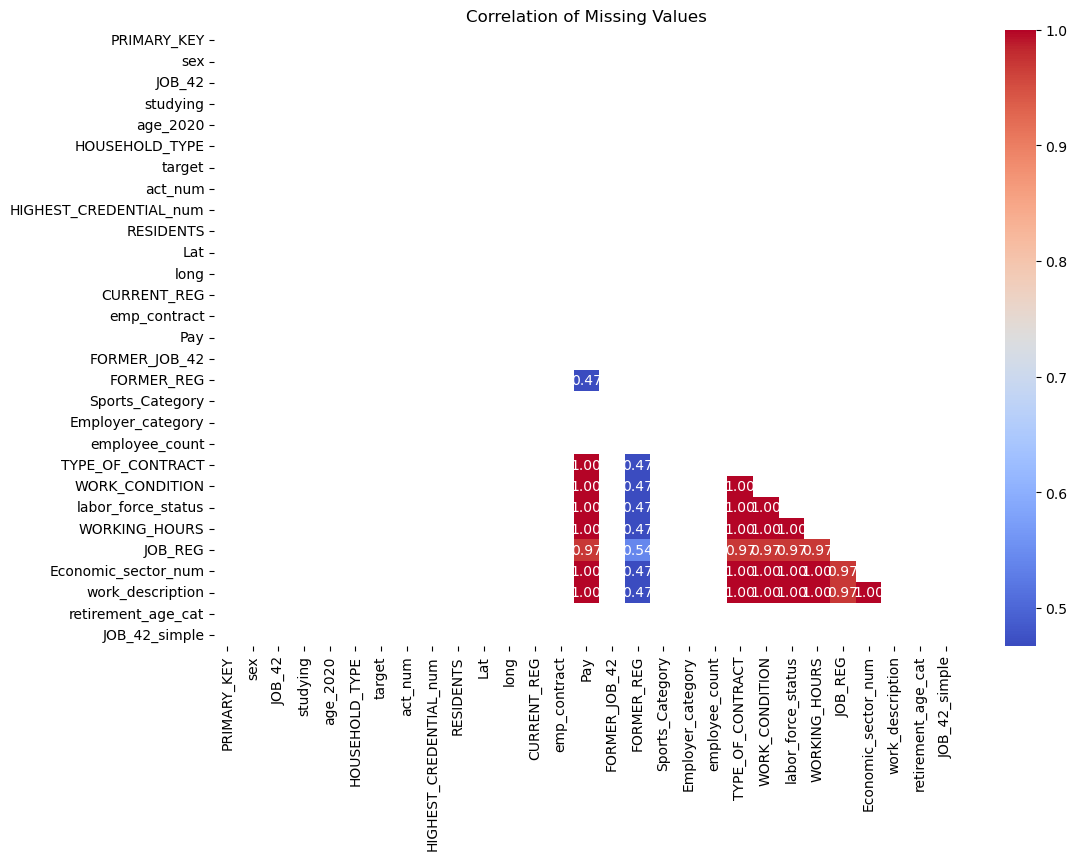

Correlation of Missing Values for Test Data


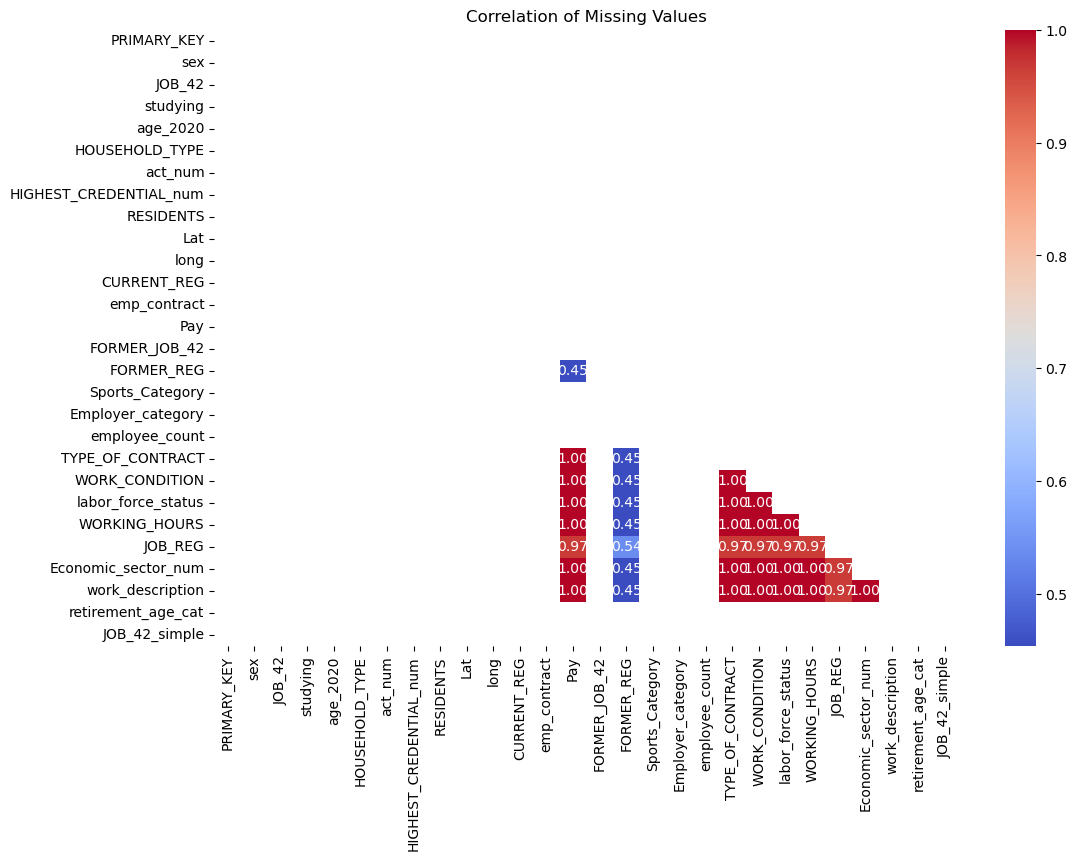

In [25]:
def plot_missing_values_correlation(df):
    """
    Plots the correlation matrix of missing values in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame with missing values.
    """
    # Calculate correlation of missing values
    missing_corr = df.isnull().corr()

    # Mask to hide the upper triangle
    mask = np.triu(np.ones_like(missing_corr, dtype=bool))

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(missing_corr, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, cbar=True)
    plt.title("Correlation of Missing Values")
    plt.show()

# Plot missing correlation for learn_data and test_data
print("Correlation of Missing Values for Learn Data")
plot_missing_values_correlation(learn_data)

print("Correlation of Missing Values for Test Data")
plot_missing_values_correlation(test_data)

In [30]:
def analyze_job_42_with_missing_values(df, threshold=5):
    """
    Identifies rows with more than a given number of missing values, groups them by JOB_42 category, 
    and calculates the count and percentage within each category.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        threshold (int): The number of missing values to filter by (default is 5).
        
    Returns:
        pd.DataFrame: A summary with counts and percentages of individuals with > threshold missing values per JOB_42 category.
    """
    # Count the number of missing values per row
    df['missing_count'] = df.isnull().sum(axis=1)

    # Filter rows with more than the threshold of missing values
    filtered_df = df[df['missing_count'] > threshold]

    # Group by JOB_42 and calculate counts
    job_42_counts = filtered_df.groupby('JOB_42')['missing_count'].count().reset_index()
    job_42_counts.rename(columns={'missing_count': 'Count'}, inplace=True)

    # Calculate total individuals per JOB_42
    total_counts = df['JOB_42'].value_counts().reset_index()
    total_counts.columns = ['JOB_42', 'Total']

    # Merge with filtered counts to calculate percentages
    job_42_summary = pd.merge(job_42_counts, total_counts, on='JOB_42')
    job_42_summary['Percentage'] = ((job_42_summary['Count'] / job_42_summary['Total']) * 100).round()

    # Drop the temporary column
    df.drop(columns=['missing_count'], inplace=True)
    
    return job_42_summary.sort_values(by='Percentage', ascending=False)


In [31]:
job_42_missing_summary = analyze_job_42_with_missing_values(learn_data, threshold=5)

print("JOB_42 categories of individuals with more than 5 missing values:")
print(job_42_missing_summary)


JOB_42 categories of individuals having more than 5 missing values:
     JOB_42  Count  Total  Percentage
0   csp_1_1    264    264       100.0
31  csp_7_1    649    649       100.0
2   csp_1_3     90     90       100.0
5   csp_2_3    181    181       100.0
1   csp_1_2     31     31       100.0
32  csp_7_2   1034   1034       100.0
3   csp_2_1    741    783        95.0
4   csp_2_2    643    694        93.0
6   csp_3_1    489    536        91.0
14  csp_4_4      9     11        82.0
9   csp_3_5    153    309        50.0
15  csp_4_5    224    446        50.0
7   csp_3_3    186    481        39.0
30  csp_6_9    116    298        39.0
8   csp_3_4    150    733        20.0
13  csp_4_3    275   1441        19.0
33  csp_7_4    215   1220        18.0
12  csp_4_2    155    862        18.0
20  csp_5_3    103    570        18.0
27  csp_6_5     56    422        13.0
18  csp_4_8     64    503        13.0
29  csp_6_8     73    801         9.0
17  csp_4_7     92   1115         8.0
34  csp_7_5    183  

In [107]:
def missing_values_by_group_for_column(df, group_col, target_col):
    # Group by `group_col` and calculate missing values for `target_col`
    grouped = df.groupby(group_col).apply(lambda group: group[target_col].isnull().sum())
    total_rows = df.groupby(group_col).size()  # Total rows per group
    missing_percent = (grouped / total_rows) * 100  # Calculate % of missing values

    # Combine counts and percentages into one DataFrame
    missing_table = pd.DataFrame({
        'Missing Values': grouped,
        '% of Total Values': missing_percent
    }).round(1)
    
    return missing_table

# Example usage
missing_job_reg_by_household = missing_values_by_group_for_column(learn_data, "JOB_42", "TYPE_OF_CONTRACT")
# change the vars here to see

print(missing_job_reg_by_household)


         Missing Values  % of Total Values
JOB_42                                    
csp_1_1             264              100.0
csp_1_2              31              100.0
csp_1_3              90              100.0
csp_2_1             741               94.6
csp_2_2             643               92.7
csp_2_3             181              100.0
csp_3_1             489               91.2
csp_3_3             186               38.7
csp_3_4             150               20.5
csp_3_5             153               49.5
csp_3_7              44                3.1
csp_3_8              52                4.0
csp_4_2             155               18.0
csp_4_3             275               19.1
csp_4_4               9               81.8
csp_4_5             224               50.2
csp_4_6             150                6.4
csp_4_7              92                8.3
csp_4_8              64               12.7
csp_5_2             136                5.8
csp_5_3             103               18.1
csp_5_4    

C:\Users\graci\AppData\Local\Temp\ipykernel_36984\2413643380.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(group_col).apply(lambda group: group[target_col].isnull().sum())


## Replacing missing values with mean

Replacement with values using external data for pay and working hours

In [105]:
# Add section here to replace missing JOB_REG with CURRENT_REG for some JOB_42 categories
# - eg artisans, agriculture...!!!!!!!!!!!!!!!!

In [26]:
# Define job-specific pay and working hours
job_defaults = {
    'csp_1': {'Pay': 50000, 'WORKING_HOURS': 2860},  # Agriculture
    'csp_2_1': {'Pay': 24000, 'WORKING_HOURS': 2288},  # Artisans
    'csp_2_2': {'Pay': 39937, 'WORKING_HOURS': 2444},  # Commerçant
    'csp_2_3': {'Pay': 58248, 'WORKING_HOURS': 2704},  # Chefs d'enterprise
}

# Function to fill missing values for Pay and WORKING_HOURS
def fill_job_defaults(data, job_defaults):
    for job, defaults in job_defaults.items():
        if job == 'csp_1':
            # Special case: Handle 'startswith' condition for 'csp_1'
            job_condition = data['JOB_42'].astype(str).str.startswith(job)
        else:
            # Exact match for other job keys
            job_condition = data['JOB_42'] == job
        
        # Fill missing Pay and WORKING_HOURS
        data.loc[job_condition & data['Pay'].isna(), 'Pay'] = defaults['Pay']
        data.loc[job_condition & data['WORKING_HOURS'].isna(), 'WORKING_HOURS'] = defaults['WORKING_HOURS']

# Apply the function to the datasets
fill_job_defaults(learn_data, job_defaults)
fill_job_defaults(test_data, job_defaults)


In [27]:
print(missing_values_table(learn_data)) 
print(missing_values_table(test_data))

There are 9 columns that have missing values.
                     Missing Values  % of Total Values
JOB_REG                        7304               14.6
TYPE_OF_CONTRACT               6939               13.9
WORK_CONDITION                 6939               13.9
labor_force_status             6939               13.9
Economic_sector_num            6939               13.9
work_description               6939               13.9
WORKING_HOURS                  5007               10.0
Pay                            4989               10.0
FORMER_REG                     2441                4.9
There are 9 columns that have missing values.
                     Missing Values  % of Total Values
JOB_REG                        7270               14.5
TYPE_OF_CONTRACT               6861               13.7
WORK_CONDITION                 6861               13.7
labor_force_status             6861               13.7
Economic_sector_num            6861               13.7
work_description            

In [28]:
missing_values_learn_data = missing_values_table(learn_data)
missing_values_test_data = missing_values_table(test_data)

# Convert the missing values table to LaTeX format
latex_learn_data = missing_values_learn_data.to_latex(index=False, float_format="%.2f")
latex_test_data = missing_values_test_data.to_latex(index=False, float_format="%.2f")

with open("./missing_values_learn_data.tex", "w") as file:
    file.write(latex_learn_data)
with open("./missing_values_test_data.tex", "w") as file:
    file.write(latex_test_data) 

There are 9 columns that have missing values.
There are 9 columns that have missing values.


# Sorting for numeric

In [29]:
# List of columns to factorize
columns_to_factorize = [  
    'JOB_42', 'JOB_REG', 'Economic_sector_num', 'work_description', 
    'retirement_age_cat', 'FORMER_REG', 'TYPE_OF_CONTRACT', 
    'WORK_CONDITION', 'labor_force_status', 'emp_contract'
]  

# Function to sort and factorize columns
def sort_and_factorize(data, columns):
    for column in columns:
        data = data.sort_values(by=column, ascending=True)
        data[column] = pd.factorize(data[column])[0]
    return data.sort_values(by='PRIMARY_KEY', ascending=True)

# Apply the function to learn_data and test_data
learn_data = sort_and_factorize(learn_data, columns_to_factorize)
test_data = sort_and_factorize(test_data, columns_to_factorize)

# Building the pipeline

In [30]:
# Custom Transformer for Handling Imputation with Averages
class ImputeMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Calculate averages for non-missing, non-zero values
        self.avg_working_hours = (
            X.loc[X["WORKING_HOURS"].notna() & (X["WORKING_HOURS"] != 0)]
            .groupby("JOB_42")["WORKING_HOURS"]
            .mean()
            .round()
        )
        self.avg_pay = (
            X.loc[X["Pay"].notna() & (X["Pay"] != 0)]
            .groupby("JOB_42")["Pay"]
            .mean()
            .round()
        )
        return self

    def transform(self, X, y=None):
        # Make a copy of X to avoid modifying the original dataframe
        X = X.copy()
        
        # Impute WORKING_HOURS using averages
        X["WORKING_HOURS"] = X.apply(
            lambda row: self.avg_working_hours.get(row["JOB_42"], np.nan)
            if pd.isnull(row["WORKING_HOURS"]) else row["WORKING_HOURS"],
            axis=1
        )
        
        # Impute Pay using averages
        X["Pay"] = X.apply(
            lambda row: self.avg_pay.get(row["JOB_42"], np.nan)
            if pd.isnull(row["Pay"]) else row["Pay"],
            axis=1
        )
        
        return X
   

In [31]:
# Custom Transformer for MICE (Multiple Imputation by Chained Equations) Imputation
class MICEImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute):
        self.columns_to_impute = columns_to_impute
        self.imputer = IterativeImputer(random_state=100)
        
    def fit(self, X, y=None):
        # Fit the imputer only on the specified columns
        self.imputer.fit(X[self.columns_to_impute])
        return self
    
    def transform(self, X):
        # Transform only the specified columns
        X_imputed = X.copy()
        X_imputed[self.columns_to_impute] = self.imputer.transform(X[self.columns_to_impute])
        return X_imputed

In [32]:
#knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
#knn_imputer.fit(df_train)
#df_imputed = knn_imputer.transform(df_train)

# Custom Transformer for MICE (Multiple Imputation by Chained Equations) Imputation
class Custom_KNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute_2):
        self.columns_to_impute_2 = columns_to_impute_2
        self.imputer = SklearnKNNImputer(n_neighbors=5, weights="uniform")
        
    def fit(self, X, y=None):
        # Fit the imputer only on the specified columns
        self.imputer.fit(X[self.columns_to_impute_2])
        return self
    
    def transform(self, X):
        # Transform only the specified columns
        X_imputed = X.copy()
        X_imputed[self.columns_to_impute_2] = self.imputer.transform(X[self.columns_to_impute_2])
        return X_imputed


In [33]:
# Specify the columns that need MICE imputation
columns_to_impute = ["Employer_category", "employee_count"]
columns_to_impute_2 = ["FORMER_REG", "JOB_REG"]

# Define the combined pipeline
pipeline = Pipeline([
    ('impute_averages', ImputeMissingValues()),  # Step 1: Impute using averages
    ('mice_imputer', MICEImputer(columns_to_impute=columns_to_impute)), 
     ('knn_imputer', Custom_KNNImputer(columns_to_impute_2=columns_to_impute_2)),
])


## Linear model

In [34]:
#for linear regression I need only number 

#do one-hot encoding for "labor_force status", but with catagegory being 0, Employed_missing, Unemployed and Other (=only being 6%)
#do one hot-encodung for "type_of_contratct" with CDI, Unemployed, Employed_Missing, Other (=only being 12%)
#do one_hot_encding for "work_condition" with Unemployed, P, Other(=only being 17%)
#do one hot_econding for "emp_contract", with EMP1-6, Unemployed, EMP2-1, Other (=being 12%)
#can keep as is for "highest_credential" because the ordinality make sense here for education
#same for the location of insee code 
#use "work condition" instead of JOB_42 and then do one-hot-encdoding
#do one-hot-encoding for "household_type"
#for "act" do one hot encoding but maybe merge stay at home people with inactif + drop less than 14years olds as nobody in our data is 
#do one hot encoding for "sport" but with a "Other" category
#do one hot encdoding for "REG_JOB" and "FORMER_REG"
#do one hot encdoding for "employer_category" with 1 to 7 being "Others
#can keep it as is for "employee count" because here the ordinality make sense
#do one hot encoding for "Economic_sector_num" and "work_description" 

In [35]:
learn_lin = pipeline.fit_transform(learn_data)

In [36]:
# check
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(learn_lin)) 

There are 2 columns that have missing values.
               Missing Values  % of Total Values
Pay                      1683                3.4
WORKING_HOURS            1683                3.4


In [37]:
#this gives 0 and 1
def preprocess_for_regression(data):
    # Initialize OneHotEncoder with sparse output disabled to return dense arrays
    ohe = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
    
    # List of columns to encode
    categorical_columns = [
        'HOUSEHOLD_TYPE', 'act_num', 'Sports_Category', 
        'Employer_category', "employee_count",
        'JOB_42', 'JOB_REG', 'Economic_sector_num', 
        'work_description', 'FORMER_REG', 'TYPE_OF_CONTRACT',
        'WORK_CONDITION', 'labor_force_status', 'emp_contract'
    ]

    # List of columns to encode categorical_columns = [
        #'labor_force_status', 'TYPE_OF_CONTRACT', 'WORK_CONDITION', 
        #'emp_contract', 'HOUSEHOLD_TYPE', 'act_num', 'Sports_Category', 
        #'REG_JOB', 'REG_FORMER', 'Employer_category', 'Economic_sector_num', 
        #'work_description' ]
    
    # Apply the encoder
    encoded_data = ohe.fit_transform(data[categorical_columns])
    
    # Create a DataFrame for the encoded features
    encoded_feature_names = ohe.get_feature_names_out(categorical_columns)
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=data.index)
    
    # Drop original categorical columns from the dataset
    data = data.drop(columns=categorical_columns)
    
    # Merge encoded features with the original dataset
    processed_data = pd.concat([data, encoded_df], axis=1)
    
    return processed_data


# Apply preprocessing to learn and test datasets
learn_lin = preprocess_for_regression(learn_lin)
#test_data = preprocess_for_regression(test_data)


In [38]:
x_train_lin = learn_lin.drop(columns=["target"])
y_train_lin = learn_lin["target"]

In [39]:
X_train_lin, X_test_lin, Y_train_lin, Y_test_lin = train_test_split(x_train_lin,
                                                    y_train_lin, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [40]:
# Example GridSearchCV for Linear Regression
param_grid = {'fit_intercept': [True, False]}  # Define your hyperparameter grid

# Create a Linear Regression model
lr = LinearRegression()

# Perform grid search with cross-validation
lin_res = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)

# Fit the GridSearchCV model
lin_res.fit(X_train_lin, Y_train_lin)

# Output the best model and its score
print(f"Best model: {lin_res.best_estimator_}")
print(f"Best score: {lin_res.best_score_}")


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\graci\anaconda3\Lib\site-packages\pandas\core\arrays\categorical.py", line 591, in astype
    new_cats = new_cats.astype(dtype=dtype, copy=copy)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'csp_1_1'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\graci\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\graci\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\sklearn\linear_model\_base.py", line 578, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 921, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\pandas\core\generic.py", line 6643, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\pandas\core\internals\managers.py", line 430, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\pandas\core\internals\managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py", line 179, in astype_array
    values = values.astype(dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graci\anaconda3\Lib\site-packages\pandas\core\arrays\categorical.py", line 602, in astype
    raise ValueError(msg)
ValueError: Cannot cast object dtype to float64


In [34]:
train_predictions = lin_res.predict(X_train_lin)
print("R² for training set: ", r2_score(Y_train_lin, train_predictions))
print("RMSE on the learning set:", root_mean_squared_error(Y_train_lin, lin_res.predict(X_train_lin)))

R² for training set:  0.5997459182730346
RMSE on the learning set: 1.3006421066980762


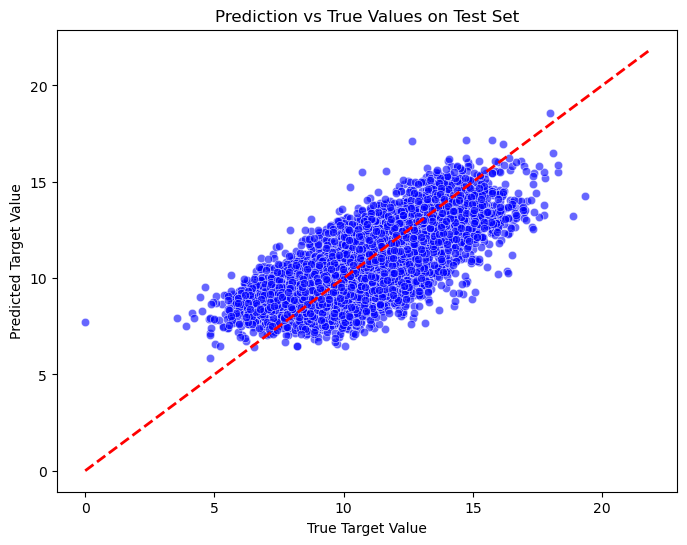

In [35]:
train_predictions = lin_res.predict(X_train_lin)
test_predictions = lin_res.predict(X_test_lin)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test_lin, y=test_predictions, alpha=0.6, color="blue")
plt.plot([y_train_lin.min(), y_train_lin.max()], [y_train_lin.min(), y_train_lin.max()], "--r", linewidth=2)  # Ideal predictions
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.savefig("./Prediction_vs_True_linear.png", format='png', dpi=300)  
plt.show()

## Random Forest model

In [36]:
learn_rf = pipeline.fit_transform(learn_data)

In [37]:
x_train_rf = learn_rf.drop(columns=["target"])
y_train_rf = learn_rf["target"]

X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(x_train_rf,
                                                    y_train_rf, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [38]:
param_grid_rf = {     # Number of trees in the forest
    'max_depth': [5, 10, 30, 50],    
    'min_samples_split': [5, 10, 20]  
}

# Define cross-validation with 5 folds
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)  #need to add that in the pipeline 

# Set up the GridSearchCV for RandomForestRegressor with appropriate scoring metric
rf_search = GridSearchCV(rf, param_grid_rf, cv=cv_folds, n_jobs=-1, scoring="neg_mean_squared_error")

In [39]:
# Fit the model on the training data
rf_res = rf_search.fit(X_train_rf, Y_train_rf)

In [40]:
# Get the best model after GridSearchCV
best_model_rf = rf_res.best_estimator_

# Output the best model and its score
print(f"Best model: {best_model_rf}")
print(f"Best score: {rf_res.best_score_}")

Best model: RandomForestRegressor(max_depth=30, min_samples_split=5, random_state=42)
Best score: -0.9352939723961082


In [41]:
cv_scores = cross_val_score(best_model_rf, X_train_rf, Y_train_rf, cv=5, scoring='r2')
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Average R2: {np.mean(cv_scores):.2f}")

Cross-validated R2 scores: [0.77934579 0.77161978 0.77423692 0.78405969 0.77844011]
Average R2: 0.78


In [42]:
train_predictions = best_model_rf.predict(X_train_rf)
test_predictions = best_model_rf.predict(X_test_rf)

print("R² for training set: ", r2_score(Y_train_rf, train_predictions))
print("R² for test set: ", r2_score(Y_test_rf, test_predictions))
print("RMSE on the learning set:", root_mean_squared_error(Y_train_rf, best_model_rf.predict(X_train_rf)))
print("RMSE on the test set:", root_mean_squared_error(Y_test_rf, best_model_rf.predict(X_test_rf)))

R² for training set:  0.9591320633274305
R² for test set:  0.7915711604764554
RMSE on the learning set: 0.415605494771625
RMSE on the test set: 0.944031678316702


In [43]:
error_metrics = pd.DataFrame({
    'Metric': ['R²', 'RMSE'],
    'Train': [r2_score(Y_train_rf, train_predictions), root_mean_squared_error(Y_train_rf, best_model_rf.predict(X_train_rf))],
    'Test': [r2_score(Y_test_rf, test_predictions), root_mean_squared_error(Y_test_rf, best_model_rf.predict(X_test_rf))]
})

# Set 'Metric' as the index to have a clean format
error_metrics.set_index('Metric', inplace=True)

# Convert to LaTeX format
error_metrics_table = error_metrics.to_latex(index=True, float_format="%.2f")

with open("./error_metrics.tex", "w") as file:
    file.write(error_metrics_table)

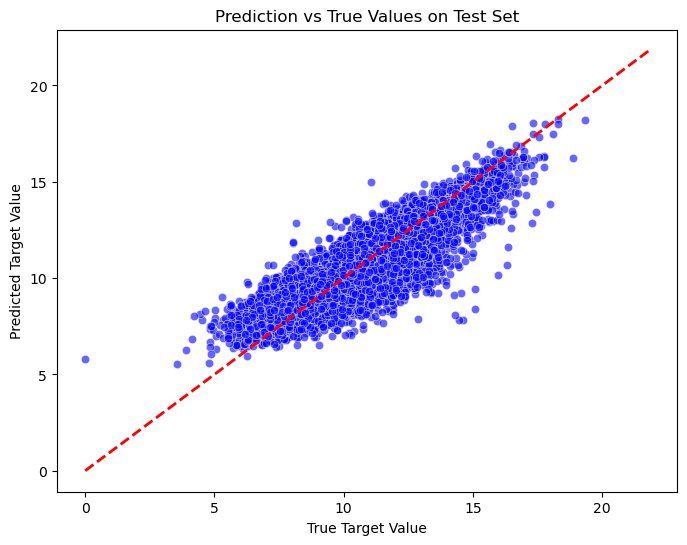

In [44]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test_rf, y=test_predictions, alpha=0.6, color="blue")
plt.plot([y_train_rf.min(), y_train_rf.max()], [y_train_rf.min(), y_train_rf.max()], "--r", linewidth=2)  # Ideal predictions
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.savefig("./Prediction_vs_True_rf.png", format='png', dpi=300)  
plt.show()

In [45]:
# Calculate correlation
correlation_matrix = learn_data.corr()

# Find correlations with the target variable
target_corr = correlation_matrix['target'].sort_values(ascending=False)

print(target_corr)

target_corr_table = target_corr.to_latex(index=False, float_format="%.2f")

with open("./target_corr.tex", "w") as file:
    file.write(target_corr_table)

target                    1.000000
studying                  0.474091
WORK_CONDITION            0.237874
work_description          0.237028
Economic_sector_num       0.228068
JOB_42                    0.225748
labor_force_status        0.205461
retirement_age_cat        0.193925
JOB_REG                   0.191613
TYPE_OF_CONTRACT          0.183736
emp_contract              0.157168
FORMER_REG                0.148466
act_num                   0.122411
employee_count            0.093330
RESIDENTS                 0.073090
Lat                       0.049312
Sports_Category           0.031436
HOUSEHOLD_TYPE           -0.016022
Employer_category        -0.017840
PRIMARY_KEY              -0.032823
long                     -0.098229
HIGHEST_CREDENTIAL_num   -0.175120
sex                      -0.180036
WORKING_HOURS            -0.200292
Pay                      -0.213074
age_2020                 -0.315319
Name: target, dtype: float64


In [46]:
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': x_train_rf.columns,
    'Importance': best_model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

feature_importances_table = feature_importances.to_latex(index=False, float_format="%.2f")

with open("./feature_importances.tex", "w") as file:
    file.write(feature_importances_table)

                   Feature  Importance
3                 studying    0.228022
7   HIGHEST_CREDENTIAL_num    0.090105
11            emp_contract    0.085129
5           HOUSEHOLD_TYPE    0.081537
1                      sex    0.072059
6                  act_num    0.061817
8                RESIDENTS    0.050154
10                    long    0.049432
0              PRIMARY_KEY    0.048544
4                 age_2020    0.044493
9                      Lat    0.036814
2                   JOB_42    0.031648
12                     Pay    0.022002
20           WORKING_HOURS    0.021022
13              FORMER_REG    0.013870
24      retirement_age_cat    0.010512
22     Economic_sector_num    0.008244
21                 JOB_REG    0.007244
14         Sports_Category    0.007053
23        work_description    0.006567
16          employee_count    0.005980
18          WORK_CONDITION    0.005364
19      labor_force_status    0.005186
15       Employer_category    0.003796
17        TYPE_OF_CONTRAC